# Soundings from Google Cloud ERA5



```{image} ../thumbnails/ecmwf.png
:alt: ECMWF logo
:width: 200px
```

```{image} ../thumbnails/google_cloud.jpg
:alt: Google Cloud logo
:width: 200px
```

---

## Overview
This notebook will also read in ERA5 reanalysis from Google cloud. Single point soundings will be the focus of this notebook. This notebook will cover:

1. Kyle Gillett's amazing `SounderPy` package
1. Subsetting the data to a single point
1. Feeding ERA5 data into SounderPy using a *clean data* dictionary
1. Comparisson to observed soundings
   

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Understanding of ERA5](https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5) | Necessary | Structure of ERA5 |
| SounderPy | Helpful | |

- **Time to learn**: 10 minutes
- **System requirements**:
    - >20 GB of system memory (Original load of ERA5 data may require some memory)

---

## Imports
--------------------------------

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from datetime import datetime as dt
from datetime import timedelta
from metpy.units import units
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import gcsfs
import sounderpy as spy


## ---------------------------------- SOUNDERPY ----------------------------------- ##
##          Vertical Profile Data Retrieval and Analysis Tool For Python            ##
##                    v3.0.9 | August 2025 | (C) Kyle J Gillett                     ##
##                 Docs: https://kylejgillett.github.io/sounderpy/                  ##
## --------------------- THANK YOU FOR USING THIS PACKAGE! ------------------------ ##



## Overview of the SounderPy Package

SounderPy is designed to be a one-stop-shop for anything soundings related. SounderPy was created by Kyle Gillett out of Central Michigan University. SounderPy allows for generation of nice, compact soundings from a variety of sources, including observed rawindsondes, soundings from reanalysis models such as RAP, ERA5, and NCAR reanalyses, as well as the option to input your own custom data using a dictionary.

Although SounderPy's functionality allows for plotting ERA5 reanalysis on its own, it requires the user have an ECMWF Climate Data Store API setup. We skip the hassle of doing that by using the ERA5 hosted on Google Cloud.

[**You can SounderPy documentation here**](https://kylejgillett.github.io/sounderpy/about.html)

## Read in ERA5 from Google Cloud

Use same process as the previous ERA5 maps notebook

In [2]:
# Use anonymous access (public dataset)
fs = gcsfs.GCSFileSystem(token="anon")

#paths to hourly full chunk era5 data
zarr_path = "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3"

data = xr.open_zarr(
    fs.get_mapper(zarr_path),
    chunks={"time": 1, "lat": 25, "lon": 25},  # adjust chunking as suited
)
data

<xarray.Dataset> Size: 4PB
Dimensions:                                                          (
                                                                      time: 1323648,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * time                                                             (time) datetime64[ns] 11MB ...
  * latitude                                                         (latitude) float32 3kB ...
  * longitude                                                        (longitude) float32 6kB ...
  * level                                                            (level) int64 296B ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    wave_spectral_skewness                                           (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    zero_degree_level                                                (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    last_updated:           2025-11-09 01:58:07.168816+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-04-30
    valid_time_stop_era5t:  2025-11-03

## Select Sounding time
We will need to adjust the formatting of the dates to be that of the time stamps used in ERA5: YYYY-MM-DD-HH:MM:SS.000000000

This example notebook will use the 27 April 2011 Super Outbreak as an example. Feel free to pick your favorite event instead!

In [3]:
year = 2011
month = 4
day = 27
hour = 18
time = dt(year,month,day,hour)



#put time into format used for times in ERA5
date = time.strftime('%Y-%m-%dT%H:%M:%S') + '.000000000' 
date

'2011-04-27T18:00:00.000000000'

## Select your sounding point
**NOTE**: ERA5 longitude is given in degrees east from 0-360. For locations in the Western hemisphere, express longitude as a negative value (i.e.-75), then add 360 to it to account for the ERA5 coordinate system

For this example, we will use the location of the Birmingham, AL (KBMX) upper air site. This will allow for a great comparison of reanalysis and observed soundings at the same location.

In [4]:
lat=33.18
lon=-86.78+360 #add 360° to convert to ERA5 longitude

## Subset the data to the times, region, and variables of interest
Much like the subsetting process done in the previous notebook, we will again use Xarray's `slice()` function to subset the data, but with one minor change to account for a single point intead of an area.

`slice()` expects to have a range of values to cover, so feeding it only a single value will cause an error and the data will not be properly subsetted. We will deal with this xarray quirk by giving it a dummy range that is less than the intervals of lat, lon, and time in ERA5.

For lat/lon, ERA5 uses a 0.25° grid. We can add and subtract a lat/lon delta of 0.25°, which will ensure that at least one grid point is indexed for any given lat/lon. This will both make xarray's `slice()` happy as now it has a range of points and return a much smaller dataset that can then be subsetted using the nearest point.

The same process can be done for time. We will set the time delta at 1h, since this version of ERA5 is hourly. We will again use the nearest time step to the selected time.

The variables to keep item is changed from the previous notebook, as now we need temperature and moisture profiles as well.

In [5]:
#only load what variables are needed
vars_to_keep=['u_component_of_wind','v_component_of_wind','temperature','specific_humidity','geopotential']

print('subsetting data')

#make model time formatted for an hour before and after the selected time to use in slice
time_m1h=(time-timedelta(hours=1)).strftime('%Y-%m-%dT%H:%M:%S') + '.000000000'
time_p1h=(time+timedelta(hours=1)).strftime('%Y-%m-%dT%H:%M:%S') + '.000000000'

#slice the data
slice_sel=data[vars_to_keep].sel(latitude=slice(lat+0.25,lat-0.25),longitude=slice(lon-0.25,lon+0.25),time=slice(time_m1h, time_p1h))

#subset the data. This will trigger a load of the much smaller dataset
sel = slice_sel.sel(latitude=lat,longitude=lon,time=date, method='nearest')

#drop the time, lat, and lon dimensions as we do not need them
sel = sel.squeeze()


subsetting data


## Define and process variables of interest

SounderPy uses MetPy functions to calculate a bunch of convective parameters, such as CAPE, CIN, Bulk Shear, SRH, Streamwiseness, etc. All these functions expect units, so all data being fed into SounderPy needs to have units attached.

SounderPy expects the following units:
- Temperature: °C
- Dew Point: °C
- Pressure: hPa
- Height/Geopotential height: meters
- U, V winds: kts

ERA5 has temperature in Kelvin, U and V in meters per second, and height in terms of geopotential. We will have to use MetPy's `to()` function to convert units. Additionally, ERA5 does not contain dew point, so we will calculate it from specific humidity using MetPy's `mpcalc.dewpoint_from_specific_humidity()` functionality.

We will assign units to the values of each variable and then convert units as needed.

In [6]:
#temp
temperature=sel.temperature.values*units.K
t=temperature.to('degC')

#pressure. pressure is the vertical coordinate, given by the 'level coordinate, already in hPa
p=sel.level.values*units.hPa

#height. convert from geopotential
z=sel.geopotential*units('m2/s2')
z_gh = mpcalc.geopotential_to_height(sel.geopotential.metpy.quantify()).values * units.meter

#wind
u=sel.u_component_of_wind.values*units('m/s')
u=u.to('kts')
v=sel.v_component_of_wind.values*units('m/s')
v=v.to('kts')

#calculate dewpoint from specific humidity
dpt=mpcalc.dewpoint_from_specific_humidity(p,sel.specific_humidity.values)

## Rearrange the datsa
ERA5's data is arranged from the top pressure level down to the ground such that pressure is increasing. All MetPy functions expect data to be aranged in order of decreasing pressure (from bottom up). Rearrange the data to be in order of decreasing pressure.

In [7]:
#sort by pressure in decreasing order
sort_idx = np.argsort(p)[::-1]

#apply to all vars
p  = p[sort_idx]
t  = t[sort_idx]
dpt = dpt[sort_idx]
u  = u[sort_idx]
v  = v[sort_idx]
z_gh  = z_gh[sort_idx]

## Set up a clean data dictionary for SounderPy to use
SounderPy has the option to generate a sounding from custom data using a clean data dictionary specified in the custom data [**documentation**](https://kylejgillett.github.io/sounderpy/customdatasources.html). We will now build the clean data dictionary


In [8]:
# declare the clean_data dictionary, leave it empty for the moment
clean_data = {}

# add profile data
clean_data['p']  = p
clean_data['z']  = z_gh
#clean_data['height'] = z_gh.m
clean_data['T']  = t
clean_data['Td'] = dpt
clean_data['u']  = u
clean_data['v']  = v

# declare some profile metadata. Since we used Birmingham AL as an example, we will give it data for Birmingham
clean_data['site_info'] = {
            'site-id'     : 'BMX',                              # could be a station ID, site ID, launch ID, mission ID, etc
            'site-name'   : 'Birmingham' ,                      # a location's "name", usually the city or town
            'site-lctn'   : 'AL',                               # could be another name, or the state
            'site-latlon' : [sel.latitude.values, sel.longitude.values-360],                  # location lat/lon, list of floats
            'site-elv'    : 175,                                # the profile's elevation in meters (int or float) (easily found on google)
            'source'      : 'ERA5',                     # the 'source' which will be the main title component of the plot
            'model'       : 'ERA',                             # model name if a model was involved
            'fcst-hour'   : f'none',                            # forecast hour if a model was involved
            'run-time'    : ['none', 'none', 'none', 'none'],   # model run date if a model was involved
            'valid-time'  : [sel.time]}      # the profile's valid date/time.

# declare the plot titles
clean_data['titles'] = {
            'top_title': 'ERA5 Modeled Sounding',
            'left_title': f'VALID: {sel.time.values}',
            'right_title': f'Grid Point [{sel.latitude.values}, {sel.longitude.values-360}]    '}

## Plot the sounding


> SOUNDING PLOTTER FUNCTION
  ---------------------------------


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


    > COMPLETE --------
    > RUNTIME: 00:00:29


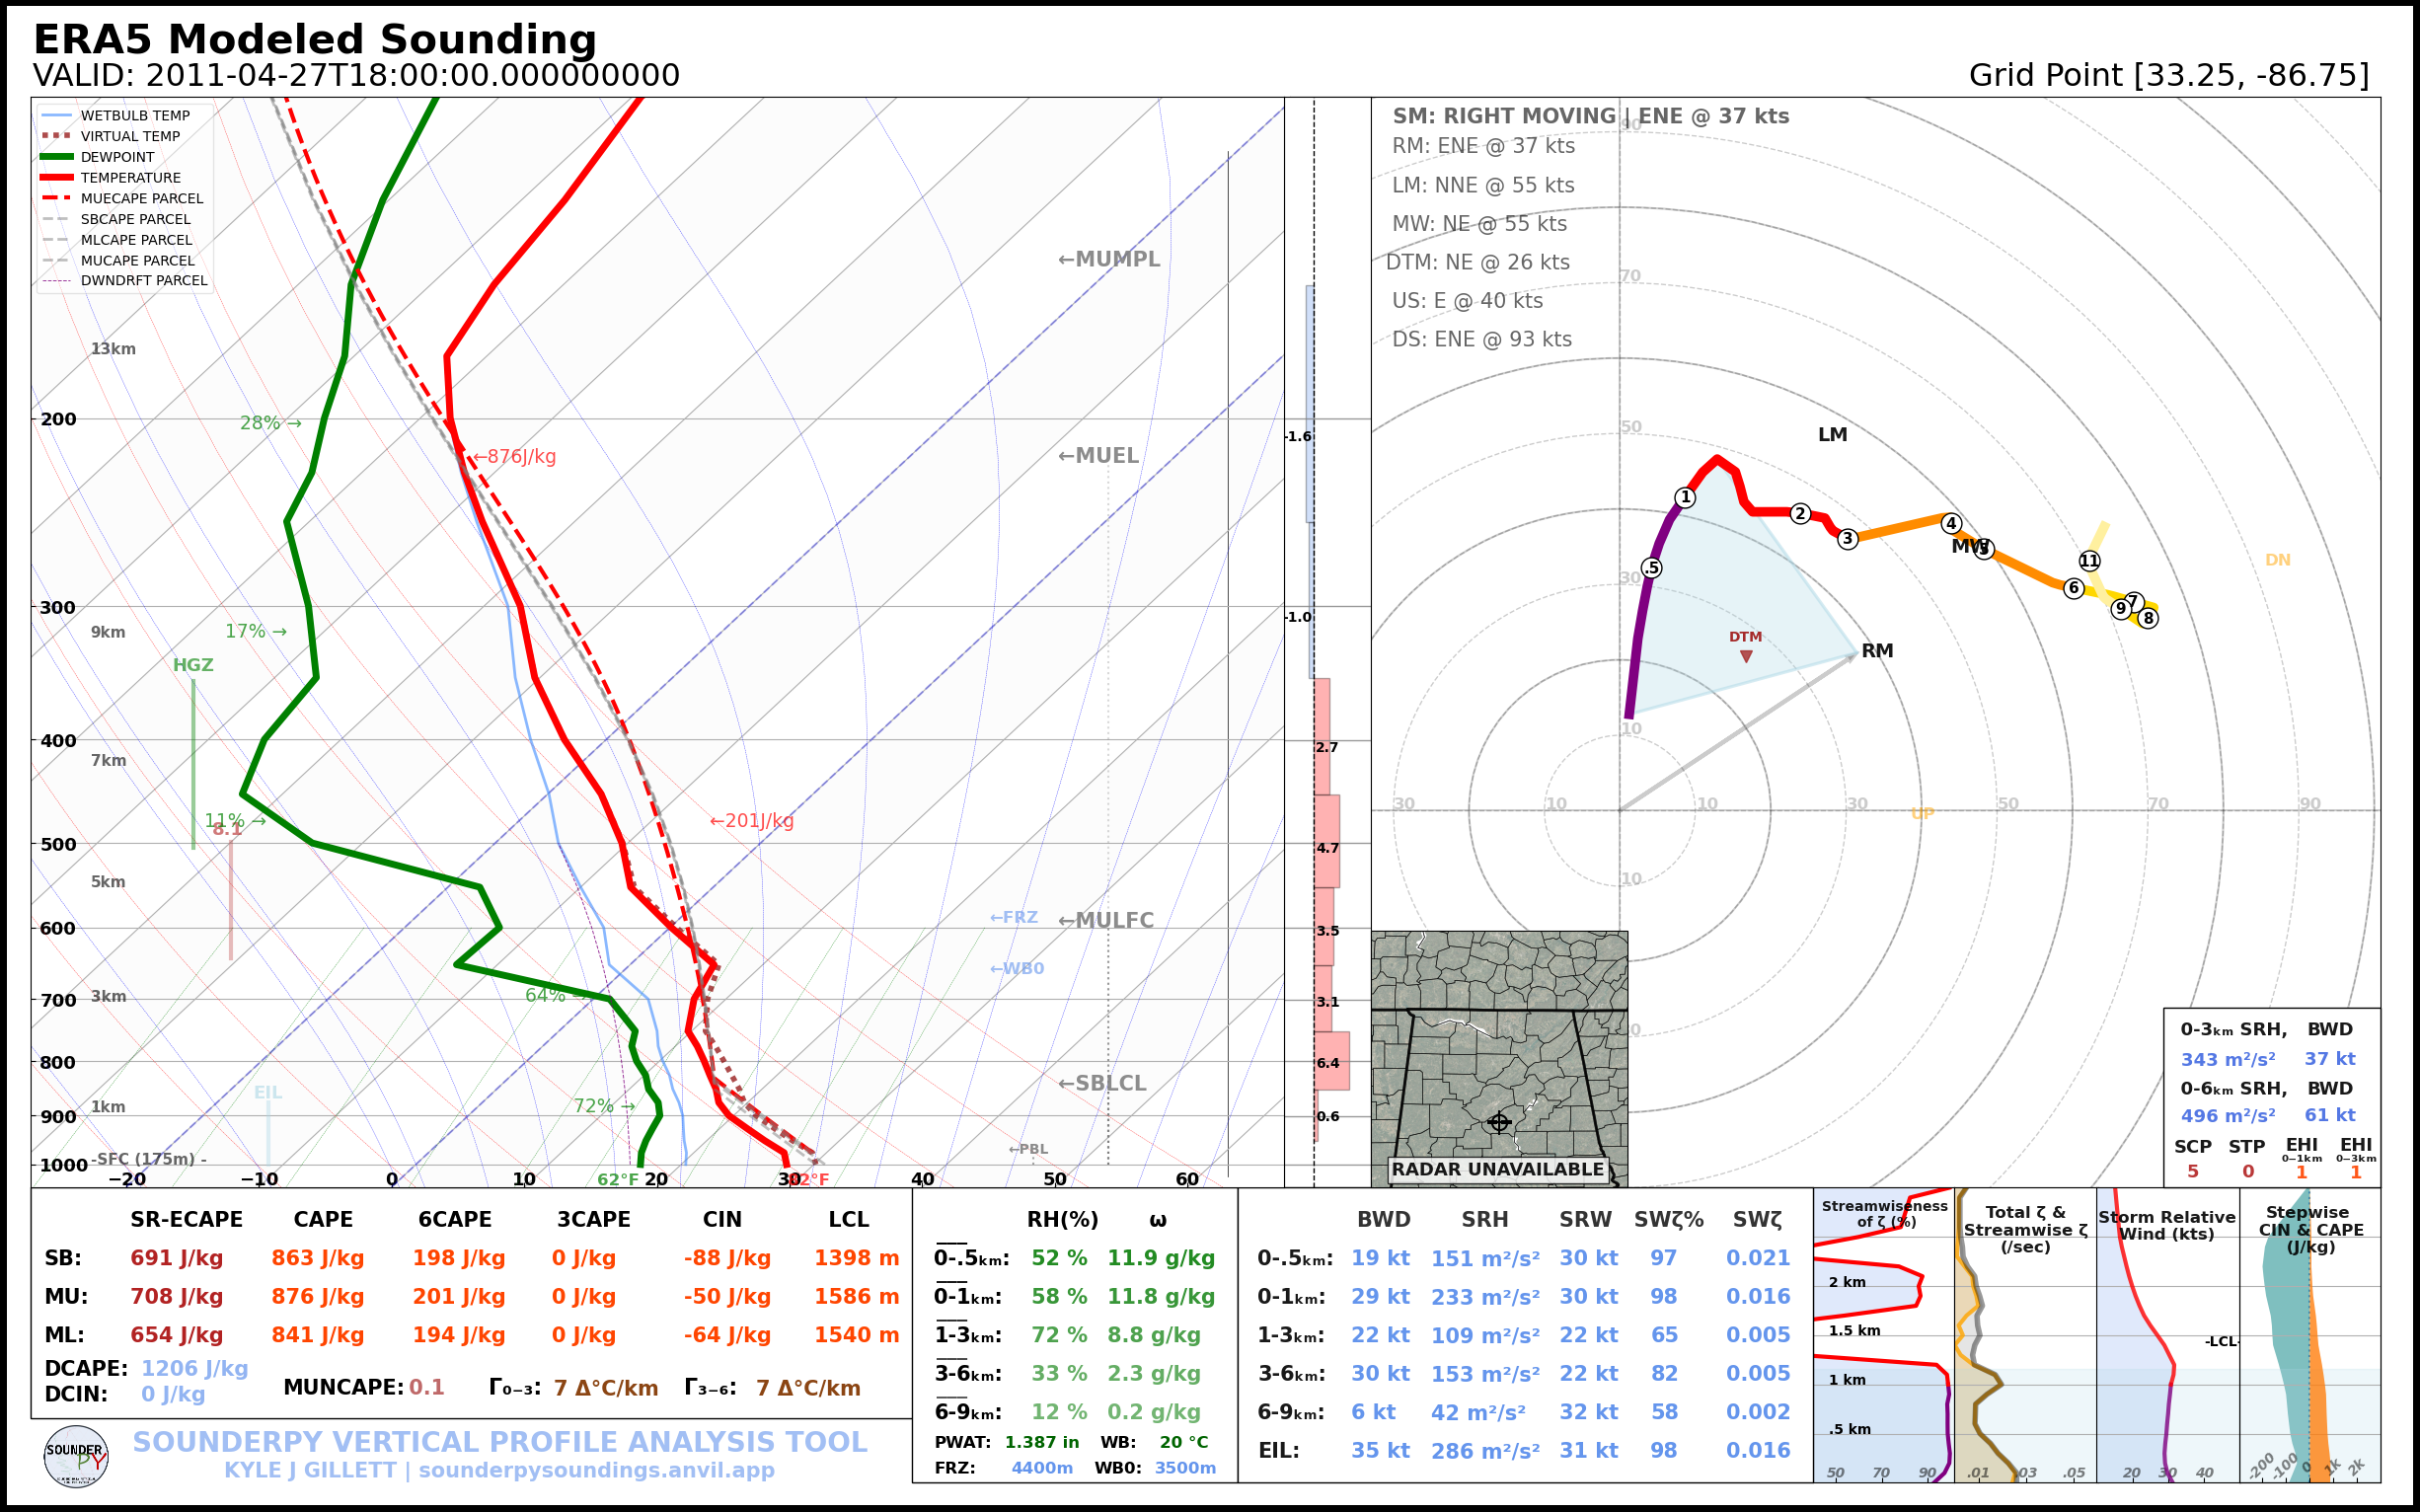

In [9]:
spy.build_sounding(clean_data)

## Compare to the observed sounding at Brimingham
We will use the `get_obs_data` function to retrieve the 18 UTC 27 April 2011 observed sounding to compare it to the ERA5 reanalysis sounding. Notice how easy it is to generate observed soundings, with only two lines of code needed!

> OBSERVED DATA ACCESS FUNCTION
  -----------------------------------
    > PROFILE FOUND: BMX on 4/27/2011 at 18z | From UW
    > COMPLETE --------
    > RUNTIME: 00:00:00
    > SUMMARY: 18Z Launch for KBMX, BIRMINGHAM/SHELBY CO. at 4-27-2011-18Z
 
    > THERMODYNAMICS --------------------------------------------- 
    --- SBCAPE: 3017.2 | MUCAPE: 3017.2 | MLCAPE: 2041.1 | MUECAPE: 2555.1
    --- MU 0-3: 210.6 | MU 0-6: 819.5 | SB 0-3: 210.6 | SB 0-6: 819.5
 
    > KINEMATICS ------------------------------------------------- 
    --- 0-500 SRW: 39.0 knot | 0-500 SWV: 0.017 | 0-500 SHEAR: 16.1 | 0-500 SRH: 159.3
    --- 1-3km SRW: 27.9 knot | 1-3km SWV: 0.011 | 1-3km SHEAR: 33.4 | | 1-3km SRH: 283.5
 
> SOUNDING PLOTTER FUNCTION
  ---------------------------------
- no radar data available -


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


    > COMPLETE --------
    > RUNTIME: 00:00:11


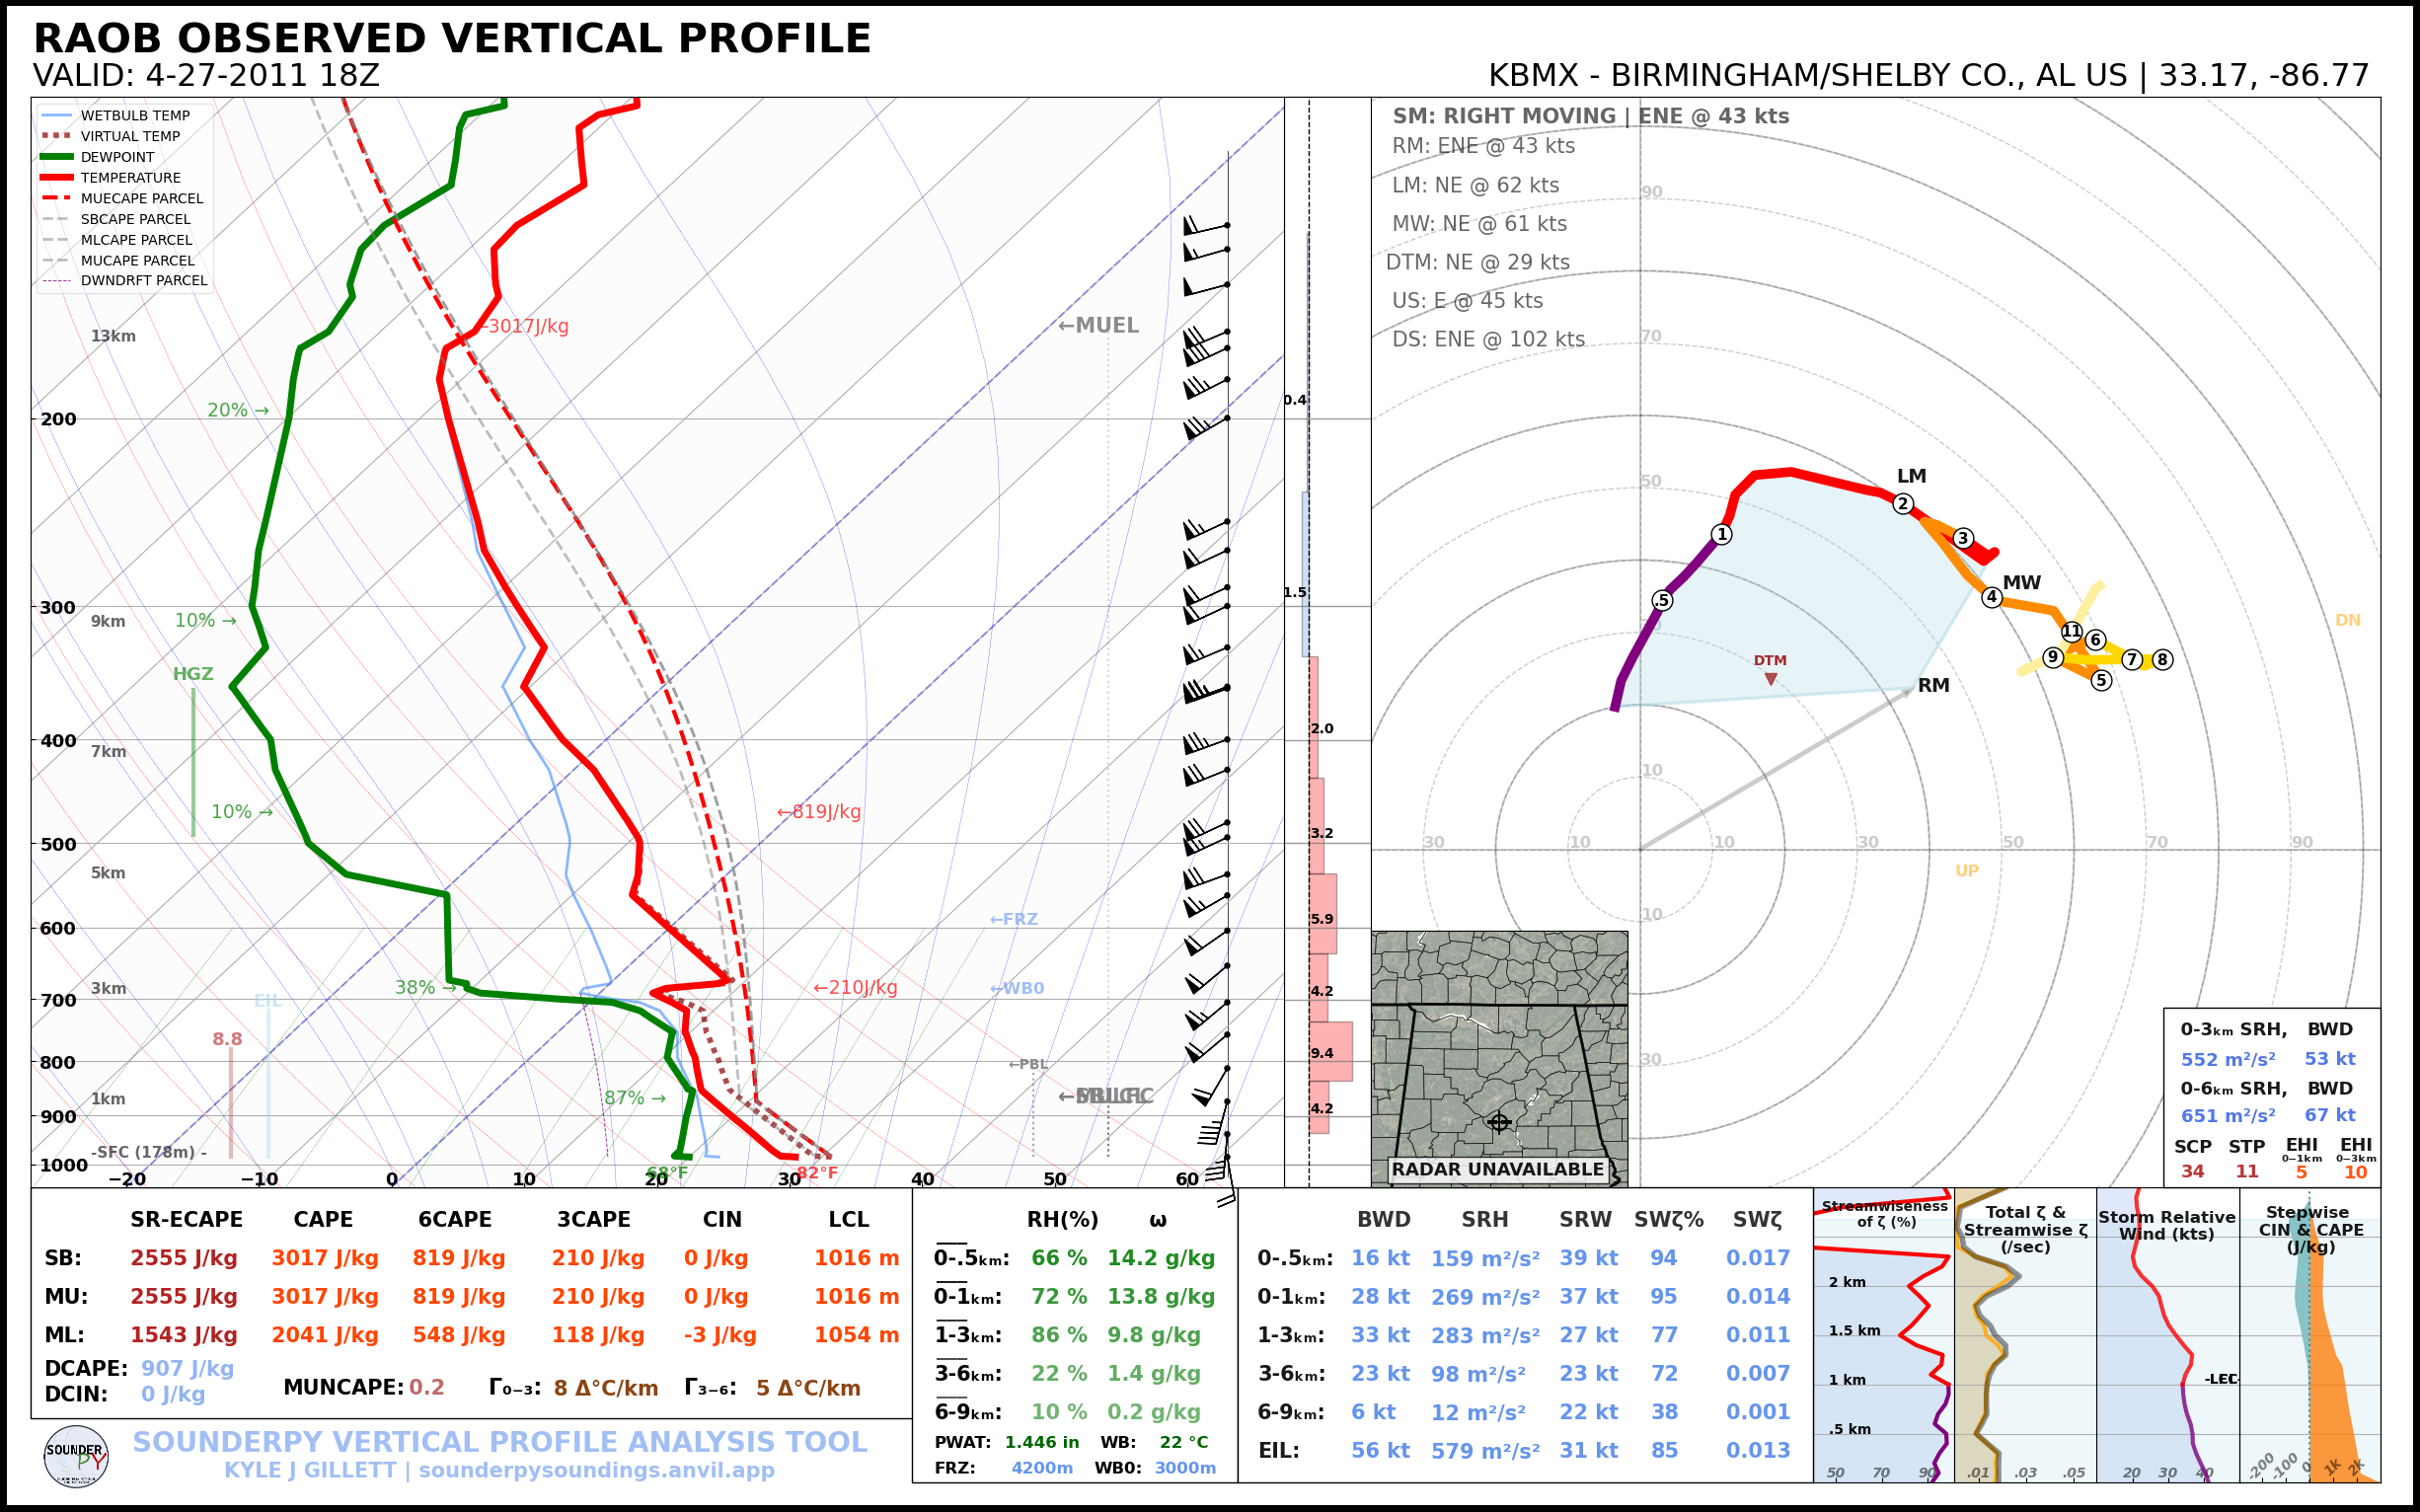

In [10]:
# This sunction takes the following: (site, year, month, day, hour(utc))
obs_data = spy.get_obs_data('BMX', '2011', '4', '27', '18')
spy.build_sounding(obs_data)

## Comparisson
Comparing the two soundings reveals some quirks of ERA5. The main difference between ERA5 and observed is that ERA5 seems to have a substantial low-level dry bias. This is a known issue with ERA5, and leads to ERA5 underrepresenting CAPE and low level moisture. This can also be seen in this comparison, as the observed sounding CAPE values between 2000 and 3000 J kg$^{-1}$ , whereas ERA5 analyzes CAPE at less than 1000 J kg$^{-1}$. This can be a big issue in the analysis of convective environments, and is something that should be known when using ERA5 reanalysis.

-------------------------------------

## Summary
We were able to plot ERA5 reanalysis using the utility of the SounderPy package through the use of a 'clean data' dictionary. Some of the flaws of ERA5 were revealed in doing this, namely it's dry bias.

### Other things to try
- Try plotting another time, and compare that time to an observed sounding. Does ERA5's dry bias show up again?
- SounderPy has the ability to plot multiple soundings to compare them. Try plotting the observed and ERA5 soundings on one plot


## Resources and references
 - ERA5 on Google Cloud: https://github.com/google-research/arco-era5
 - [SounderPy Documentation](https://kylejgillett.github.io/sounderpy/about.html)
 - [Making a sounding from your own data](https://kylejgillett.github.io/sounderpy/customdatasources.html)
 
